# Import

In [1]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import *
from src.models.model_util import *
from src.data.data_util import *
from src.visualization.auggrad import *
from src.visualization.cams import *
from src.visualization.visual_utils import *
from src.visualization.vistool_pipeline import *

from IPython.display import clear_output

In [14]:
# LOAD CONFIG
cfg = load_config()

# MODEL CONFIG

### MODEL -- RESNET_NO_MAXPOOL / 64/128/256/512 / 2021_04_07_1408_resnet_no_maxpool
# cfg.model_name = 'resnet_no_maxpool'
# cfg.start_channels = 64
# model, cfg.device = load_model(cfg.model_name, verbose=False, cfg=cfg)
# model.load_state_dict(torch.load('./result/models/2021_04_07_1408_resnet_no_maxpool/resnet_no_maxpool_ep70-100_sd42_mae6.241.pth/'))
###

### MODEL -- RESNET_NO_MAXPOOL / 16/32/64/128/ / 2021_04_15_1106_resnet_no_maxpool
cfg.model_name = 'resnet_no_maxpool'
model, cfg.device = load_model(cfg.model_name, verbose=False, cfg=cfg)
model.load_state_dict(torch.load('./result/models/2021_04_15_1106_resnet_no_maxpool/best_resnet_no_maxpool_ep94-100_sd42_mae6.160.pth'))
###
# Dataloader
# cfg.return_path = True
train_dataset = DatasetPlus(cfg, augment=False, test=True)
sample_dl = DataLoader(train_dataset, batch_size=1)

# FOR SINGLE BRAIN
# x, y = train_dataset[15]
# x = x[None, ...]

G:\My Drive\brain_data\workspace\3d_brain\src\config.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return CFG(yaml.load(yml_config_file))


Model Resnet_no_maxpool is selected.


In [ ]:
gcam = VisTool(cfg, model, cam_type='gcam')
path = './result/models/2021_04_15_1106_resnet_no_maxpool/*.pth'
gcam.run_pretrains_dataloader(path, sample_dl, layer_index=8, visualize=False)

3th Pretrained
Weights successfully loaded!
175 brains in total.
0.000% DONE.
[true]: 64 [pred]: 6.259
[true]: 81 [pred]: 2.601
[true]: 32 [pred]: -0.987
[true]: 61 [pred]: 6.499
[true]: 38 [pred]: 0.364
[true]: 70 [pred]: 2.707
[true]: 52 [pred]: 6.410
[true]: 68 [pred]: 2.347
[true]: 72 [pred]: 6.363
[true]: 54 [pred]: 6.439
5.714% DONE.
[true]: 81 [pred]: 2.923
[true]: 21 [pred]: -0.834
[true]: 77 [pred]: 1.882
[true]: 32 [pred]: -0.285
[true]: 35 [pred]: 0.310
[true]: 43 [pred]: -0.784
[true]: 53 [pred]: -0.686
[true]: 61 [pred]: 0.303
[true]: 82 [pred]: 2.833
[true]: 62 [pred]: 0.210
11.429% DONE.
[true]: 23 [pred]: -0.573
[true]: 80 [pred]: 6.025
[true]: 80 [pred]: 1.733
[true]: 42 [pred]: 0.072
[true]: 23 [pred]: 0.028
[true]: 53 [pred]: 5.446
[true]: 44 [pred]: 0.617
[true]: 29 [pred]: -0.110
[true]: 51 [pred]: 0.416
[true]: 32 [pred]: -0.863
17.143% DONE.
[true]: 77 [pred]: 6.360
[true]: 66 [pred]: 2.186
[true]: 22 [pred]: -0.082
[true]: 64 [pred]: 6.308
[true]: 80 [pred]: 6.3

In [3]:
# sgrad = VisTool(cfg, model, cam_type='sgrad')
# path = './result/models/2021_04_15_1106_resnet_no_maxpool/*.pth'
# sgrad.run_pretrains_dataloader(path, sample_dl, visualize=False)

In [ ]:
# agrad = VisTool(cfg, model, cam_type='agrad')
# path = './result/models/2021_04_07_1408_resnet_no_maxpool/*.pth'
# agrad.run_pretrains_dataloader(path, sample_dl, visualize=False)

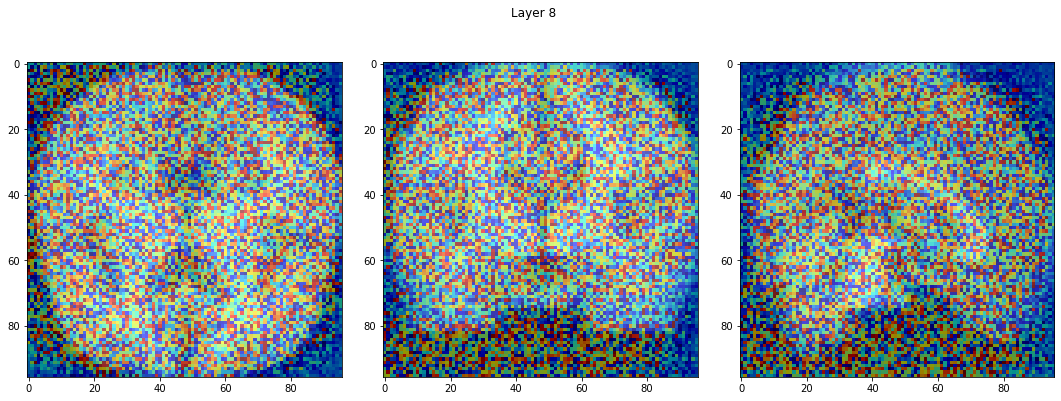

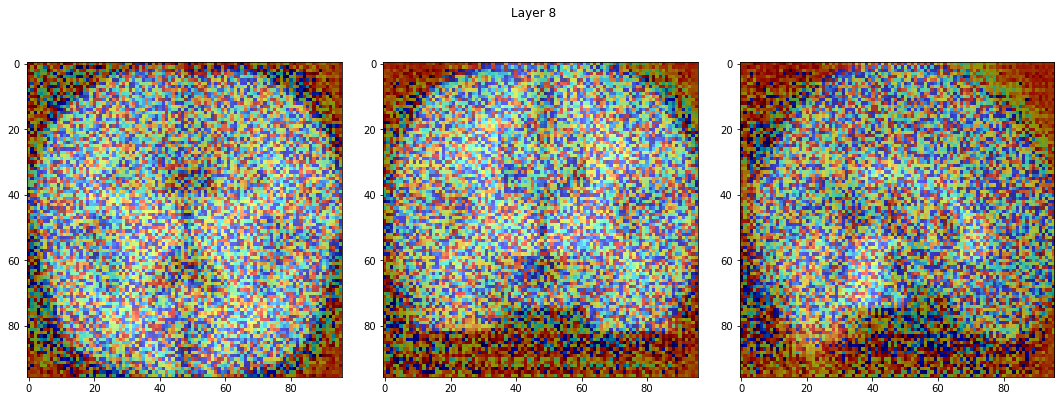

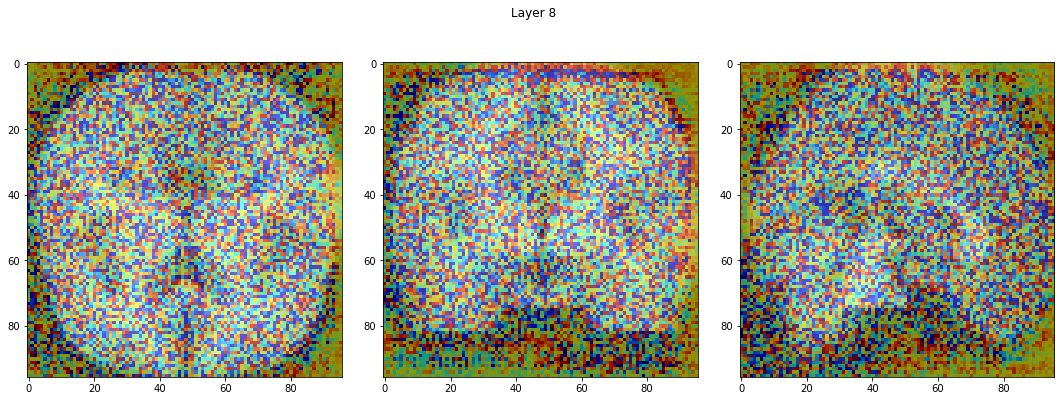

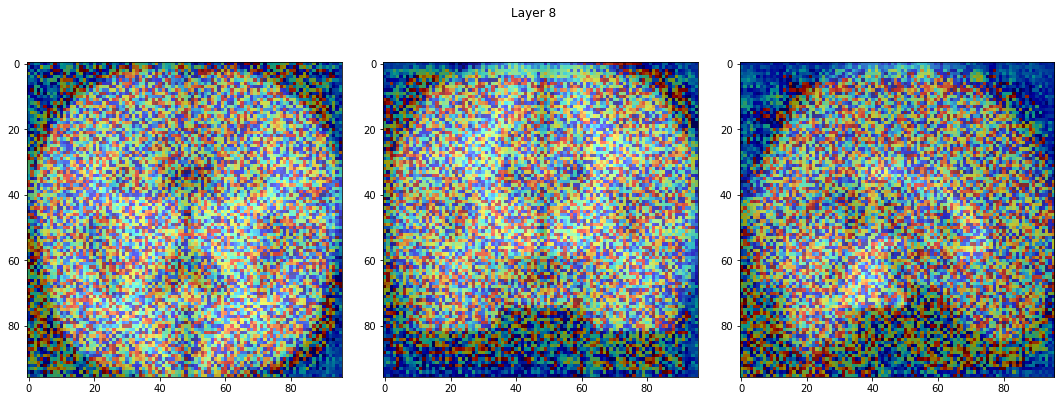

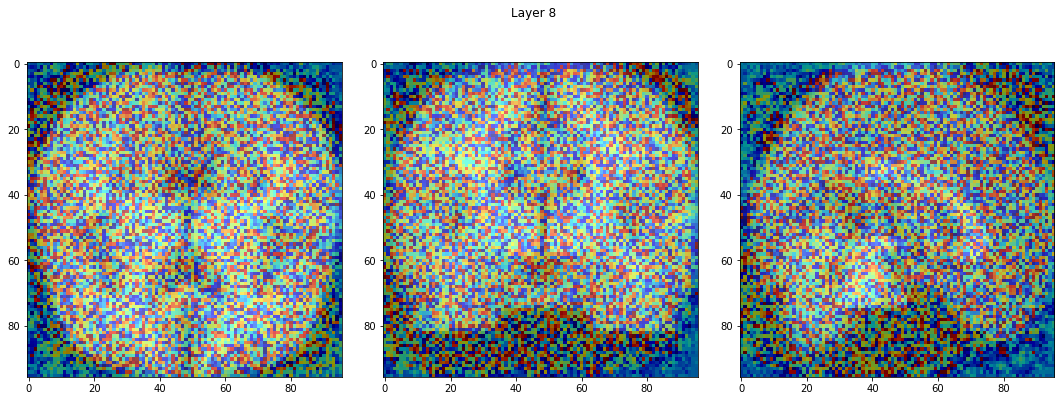

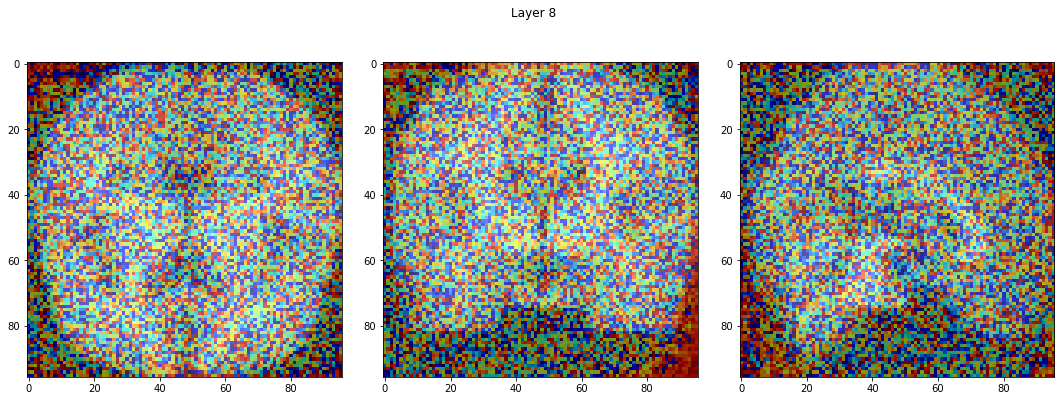

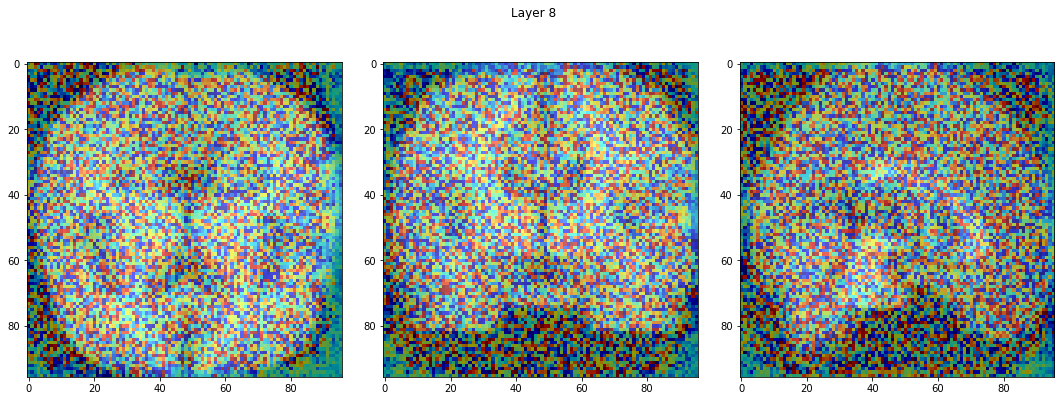

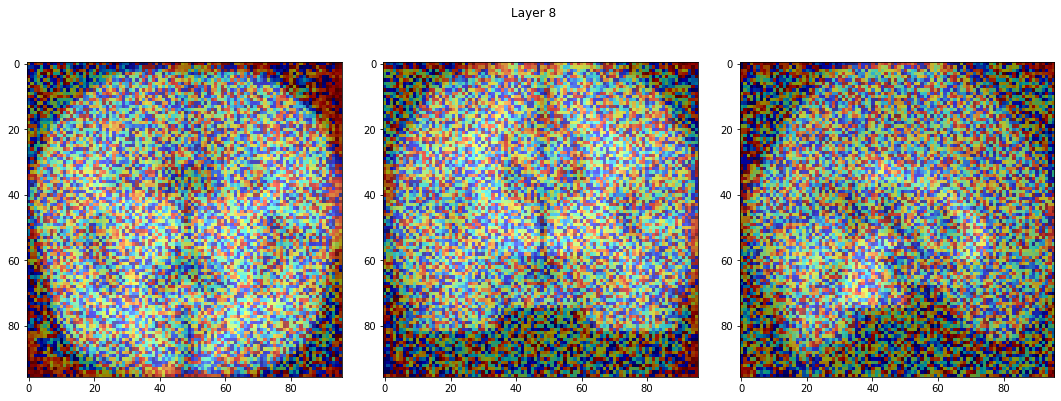

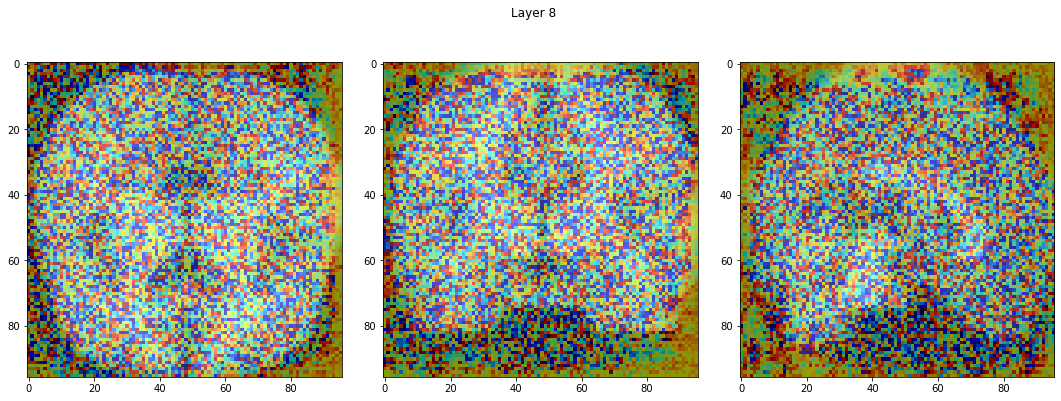

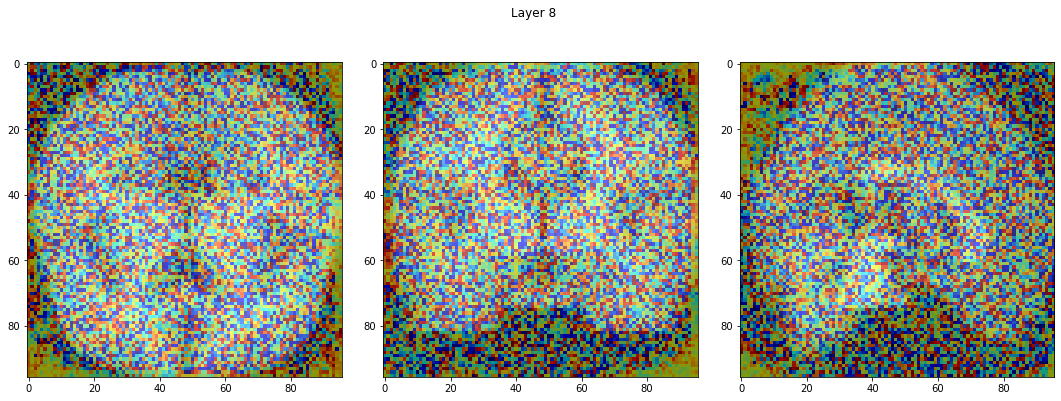

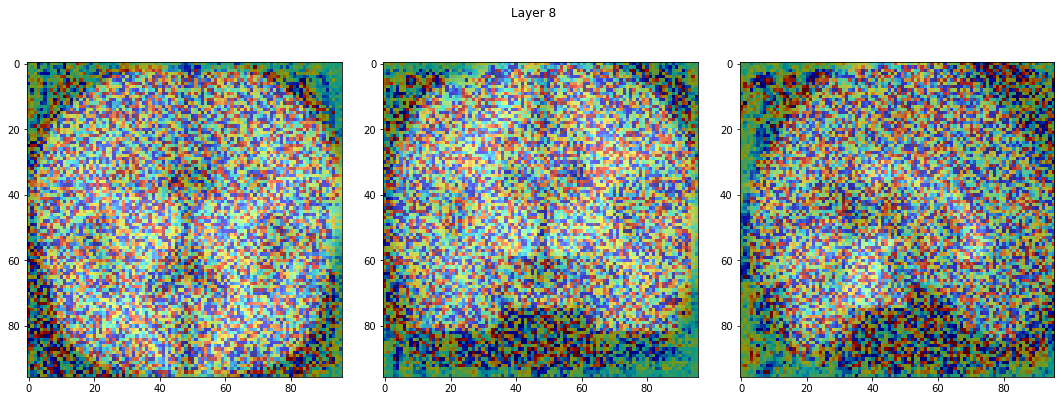

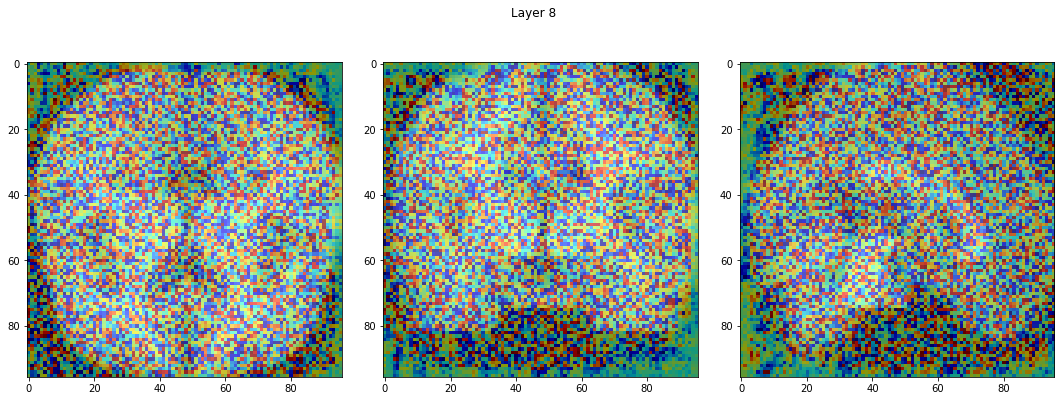

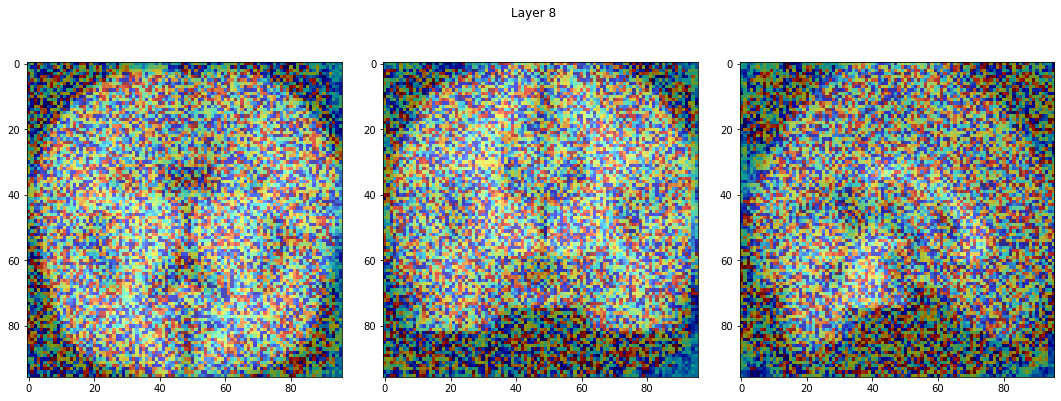

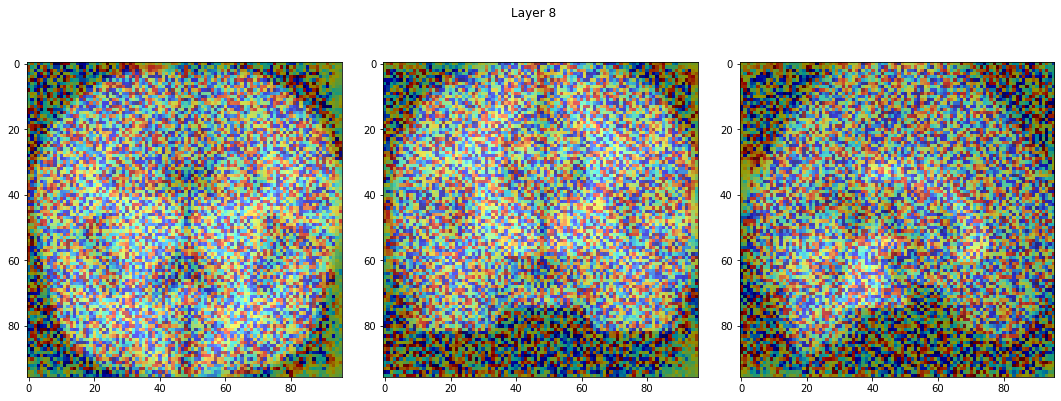

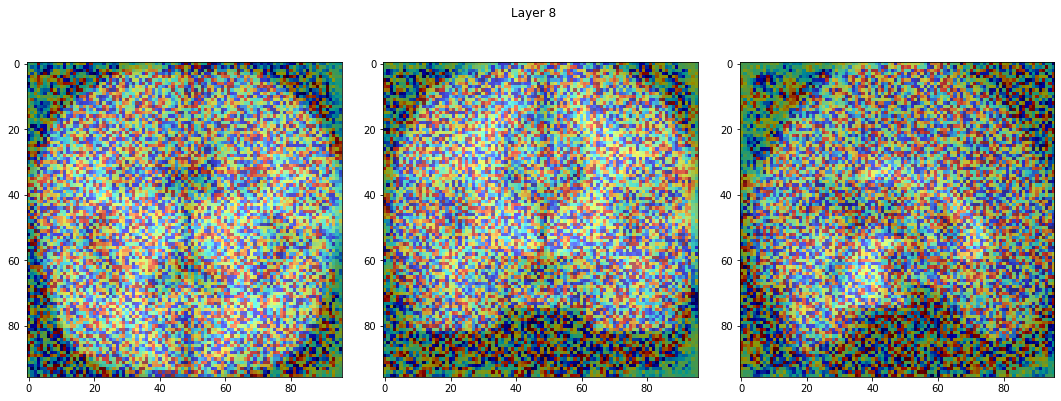

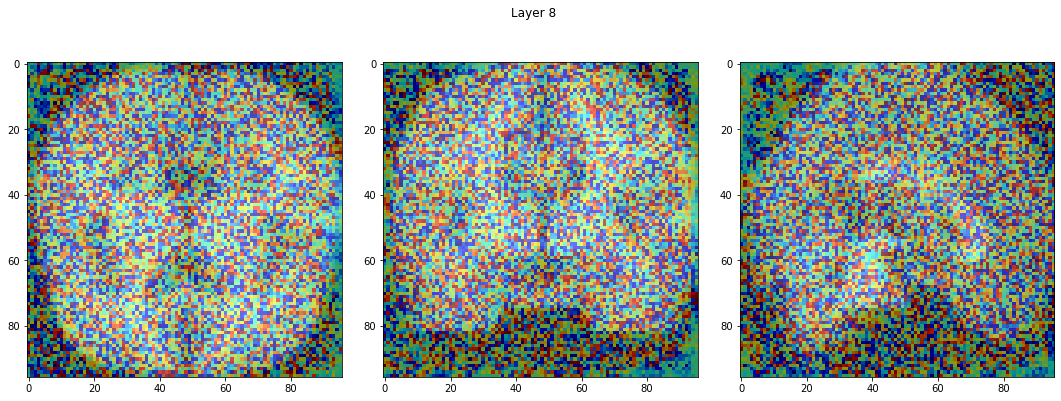

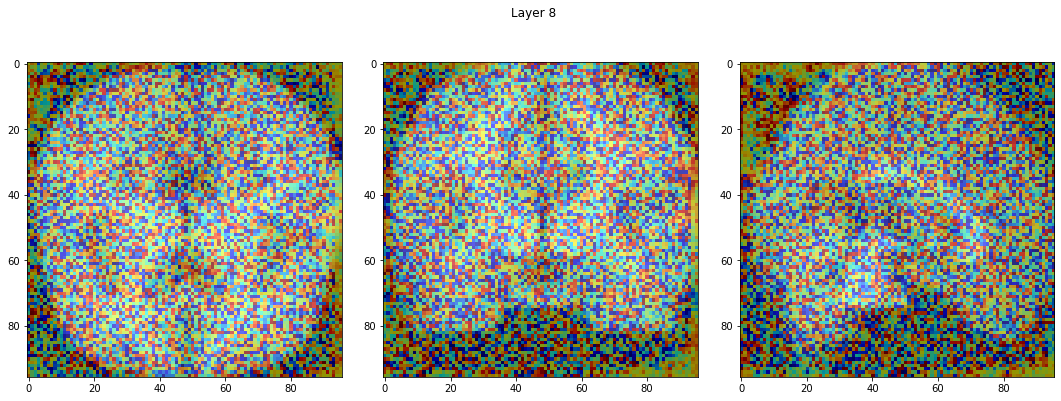

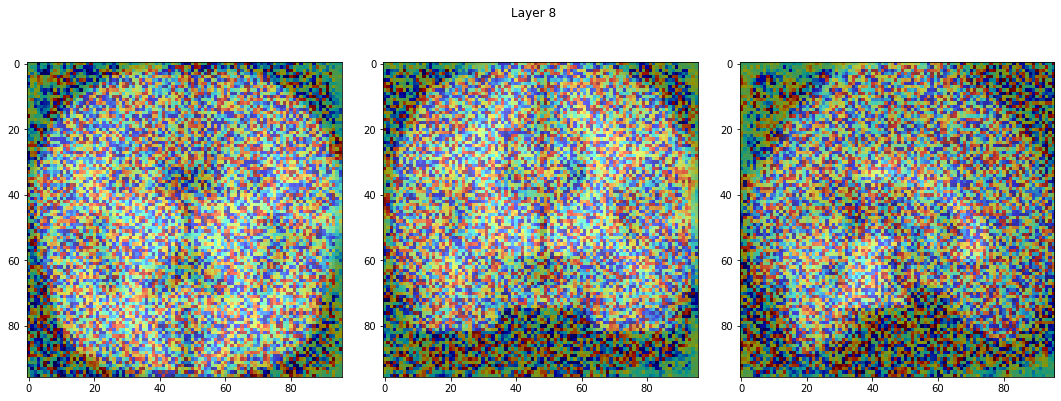

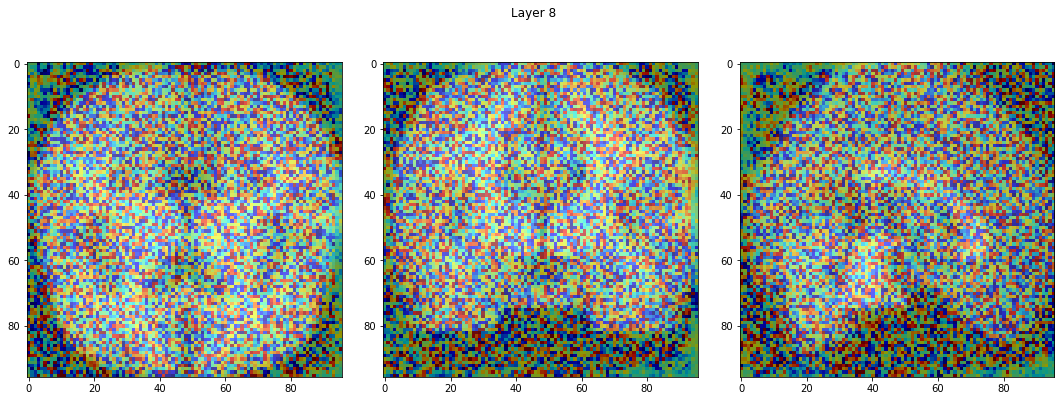

In [4]:
# make averaged_brain + vismap
averaged_brain = F.interpolate(torch.tensor(np.load('../../brainmask_tlrc/averaged_brain_no_oas3.npy'))[None, None, ...],
                              size=(96, 96, 96))
att_path='./result/attention_maps/0407_resnet_averaged_scam/'
for i, v in enumerate(sgrad.vismap_ts):
    plot_vismap(brain=averaged_brain, vismap=torch.tensor(v), idx=i, title='Layer 8',
                save=True, att_path=att_path)
    
    np.save(f'{att_path}/{str(i).zfill(3)}.npy', v)

In [17]:
att_path='./result/attention_maps/0407_resnet_averaged_gcam_layer8/'
with imageio.get_writer(f'{att_path}/avg.gif', mode='I') as writer:
    for im in sorted(glob(f'{att_path}/*.png')):
        image = imageio.imread(im)
        writer.append_data(image)